# Group1 - Final Project - EDA and LSTM model on defog

### Sihe Zheng, szheng12@depaul.edu
### YunTzu Yu, yyu54@depaul.edu
### Saruul Enkhtur, senkhtur@depaul.edu
### Lukasz Grzybek, lgrzybek@depaul.edu


#### DePaul University, College of Computing and Digital Media,
#### DSC 672 DATA SCIENCE CAPSTONE

## Import Package For this project

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import json
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
import IPython.display
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Flatten, Conv1D, MaxPooling1D, Dropout, GRU, SimpleRNN
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import gc
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler

## Function for Reducing Memory Usage

In [ ]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage became: ",mem_usg," MB")

    return df

## Load Defog Data

In [ ]:
data_dir='/content/drive/MyDrive/DSC672/data/'
daily_metadata_file = f'{data_dir}daily_metadata.csv'
defog_metadata_file = f'{data_dir}defog_metadata.csv'
tdcsfog_metadata_file = f'{data_dir}tdcsfog_metadata.csv'
events_data_file = f'{data_dir}events.csv'
subjects_data_file = f'{data_dir}subjects.csv'
tasks_data_file = f'{data_dir}tasks.csv'

# Read the meta data
daily_metadata = pd.read_csv(daily_metadata_file)
defog_metadata = pd.read_csv(defog_metadata_file)
tdcsfog_metadata = pd.read_csv(tdcsfog_metadata_file)

events_data = pd.read_csv(events_data_file)
subjects_data = pd.read_csv(subjects_data_file)
tasks_data = pd.read_csv(tasks_data_file)

In [ ]:
#read defog for the train dataset
DATA_ROOT_DEFOG = '/content/drive/MyDrive/DSC672/data/train/defog'
defog = pd.DataFrame()
for root, dirs, files in os.walk(DATA_ROOT_DEFOG):
    for name in files:
        f = os.path.join(root, name)
        df_list= pd.read_csv(f)
        words = name.split('.')[0]
        df_list['file']= name.split('.')[0]
        defog = pd.concat([defog, df_list], axis=0)
defog

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,file
0,0,-0.949674,0.027301,-0.358175,0,0,0,False,False,06414383cf
1,1,-0.949707,0.027119,-0.361305,0,0,0,False,False,06414383cf
2,2,-0.951082,0.024896,-0.361723,0,0,0,False,False,06414383cf
3,3,-0.950639,0.025920,-0.358969,0,0,0,False,False,06414383cf
4,4,-0.952554,0.027264,-0.357626,0,0,0,False,False,06414383cf
...,...,...,...,...,...,...,...,...,...,...
123967,123967,-0.991344,-0.079444,-0.089216,0,0,0,False,False,f9efef91fb
123968,123968,-0.991866,-0.077738,-0.093203,0,0,0,False,False,f9efef91fb
123969,123969,-0.989502,-0.076468,-0.094360,0,0,0,False,False,f9efef91fb
123970,123970,-0.989688,-0.073600,-0.095155,0,0,0,False,False,f9efef91fb


In [ ]:
#reduce memory usage for defog
defog = reduce_memory_usage(defog)

Memory usage of dataframe is 954.53 MB
Memory usage became:  335.3796806335449  MB


In [ ]:
#drop off the invalid dataset in defog
defog_data_valid = defog.loc[(defog.Valid == True) & (defog.Task == True)]

defog_data_valid = defog_data_valid.drop(columns=['Valid', 'Task'])

defog_data_valid

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,file
1000,1000,-0.953613,0.023209,-0.397949,0,0,0,06414383cf
1001,1001,-0.963867,0.024414,-0.398438,0,0,0,06414383cf
1002,1002,-0.968262,0.028320,-0.387939,0,0,0,06414383cf
1003,1003,-0.965332,0.028351,-0.371582,0,0,0,06414383cf
1004,1004,-0.954590,0.029755,-0.362061,0,0,0,06414383cf
...,...,...,...,...,...,...,...,...
122967,122967,-0.936035,-0.098633,-0.055573,0,0,0,f9efef91fb
122968,122968,-0.941406,-0.122864,-0.083069,0,0,0,f9efef91fb
122969,122969,-0.940918,-0.134033,-0.107422,0,0,0,f9efef91fb
122970,122970,-0.945312,-0.130981,-0.117310,0,0,0,f9efef91fb


In [ ]:
defog_metadata = pd.read_csv(defog_metadata_file)
defog_metadata

,Id,Subject,Visit,Medication
0,02ab235146,e1f62e,2,on
1,02ea782681,ae2d35,2,on
2,06414383cf,8c1f5e,2,off
3,092b4c1819,2874c5,1,off
4,0a900ed8a2,0e3d49,2,on
...,...,...,...,...
132,f3a921edee,1a778d,1,off
133,f40e8c6ebe,575c60,1,off
134,f8ddbdd98d,107712,1,on
135,f9efef91fb,5d9cae,2,off


In [ ]:
defog_m= defog_metadata.merge(defog_data_valid, how = 'inner', left_on = 'Id', right_on = 'file')
defog_m.drop(['file'], axis = 1, inplace = True)
defog_m=reduce_memory_usage(defog_m)

Memory usage of dataframe is 206.75 MB
Memory usage became:  97.52996635437012  MB


In [ ]:
defog_m.memory_usage().sum() / 1024**2

97.52996635437012

In [ ]:
defog_m

,Id,Subject,Visit,Medication,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
0,02ea782681,ae2d35,2,on,1000,-0.970215,0.061615,-0.265625,0,0,0
1,02ea782681,ae2d35,2,on,1001,-0.984375,0.044495,-0.265625,0,0,0
2,02ea782681,ae2d35,2,on,1002,-0.984375,0.029022,-0.265625,0,0,0
3,02ea782681,ae2d35,2,on,1003,-0.984375,0.015625,-0.265625,0,0,0
4,02ea782681,ae2d35,2,on,1004,-0.984863,0.015327,-0.265625,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4090525,f9fc61ce85,040587,1,on,119027,-0.961426,0.142456,-0.289551,0,0,0
4090526,f9fc61ce85,040587,1,on,119028,-0.960449,0.142822,-0.290527,0,0,0
4090527,f9fc61ce85,040587,1,on,119029,-0.958008,0.145508,-0.290039,0,0,0
4090528,f9fc61ce85,040587,1,on,119030,-0.960449,0.145874,-0.291504,0,0,0


## EDA

In [ ]:
# Display basic information about the dataset
print("Basic Info:")
print(defog_m.info())

# Summary statistics
print("\nSummary Statistics:")
print(defog_m.describe())

# Check for missing values
print("\nMissing Values:")
print(defog_m.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:")
print(defog_m.duplicated().sum())

# Distribution of categorical variables
print("\nDistribution of Categorical Variables:")
for col in defog_m.select_dtypes(include=['category']).columns:
    print("\n", col, ":")
    print(defog_m[col].value_counts())

Basic Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4090530 entries, 0 to 4090529
Data columns (total 11 columns):
 #   Column           Dtype   
---  ------           -----   
 0   Id               category
 1   Subject          category
 2   Visit            int8    
 3   Medication       category
 4   Time             int32   
 5   AccV             float16 
 6   AccML            float16 
 7   AccAP            float16 
 8   StartHesitation  int8    
 9   Turn             int8    
 10  Walking          int8    
dtypes: category(3), float16(3), int32(1), int8(4)
memory usage: 97.5 MB
None

Summary Statistics:
              Visit          Time          AccV         AccML         AccAP  \
count  4.090530e+06  4.090530e+06  4.090530e+06  4.090530e+06  4.090530e+06   
mean   1.350975e+00  9.112536e+04           NaN -0.000000e+00           NaN   
std    4.772752e-01  7.025916e+04  0.000000e+00  0.000000e+00  0.000000e+00   
min    1.000000e+00  1.000000e+03 -6.023438e+00 -2.115234

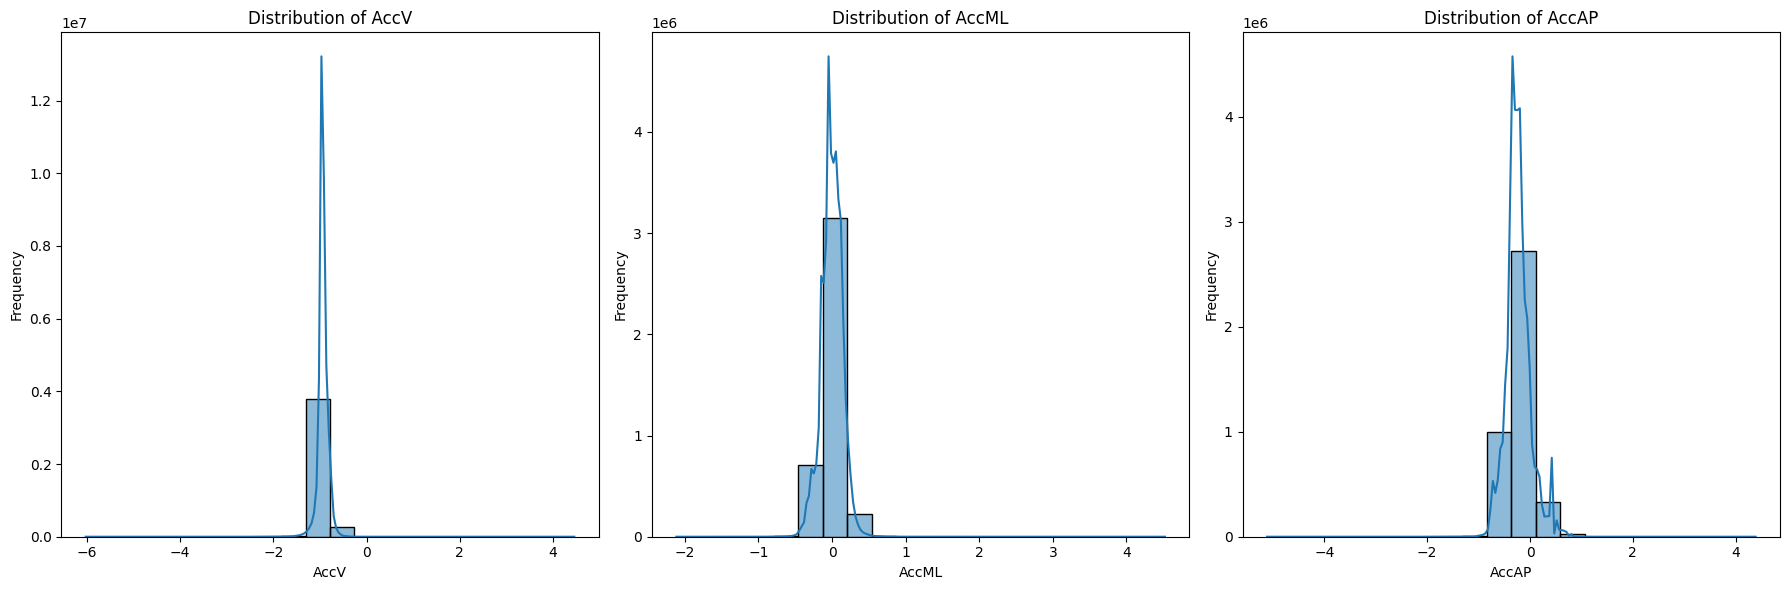

In [ ]:
# Visualizations - Distribution of Features

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Plot histogram for AccV
sns.histplot(defog_m['AccV'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution of AccV')
axes[0].set_xlabel('AccV')
axes[0].set_ylabel('Frequency')

# Plot histogram for AccML
sns.histplot(defog_m['AccML'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution of AccML')
axes[1].set_xlabel('AccML')
axes[1].set_ylabel('Frequency')

# Plot histogram for AccAP
sns.histplot(defog_m['AccAP'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution of AccAP')
axes[2].set_xlabel('AccAP')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Total Entries: 4090530

Columns: 11

Data Types:

*   Object: Id, Subject, Medication
*   Integers: Visit, Time
*   Floats: AccV, AccML, AccAP
*   Categorical(0/1): StartHesitation, Turn, Walking

Memory Usage: Approximately 97.5 MB

Summary Statistics:

*   Visits: Mean visit count is approximately 1.35 with a standard deviation of approximately 0.48.
*   Time: The data spans a range from 1 to approximately 414387 with a mean time of approximately 91125.
*   Acceleration (AccV, AccML, AccAP): The mean, standard deviation, and range vary for each acceleration component.
*   Categorical Variables (StartHesitation, Turn, Walking): The mean values indicate the proportion of occurrences for each category.These categories are binary, with 0 indicating absence and 1 indicating presence.

Missing Values: No missing values were found for any column.

Duplicate Rows: No duplicate rows were found.

Distribution of Categorical Variables:

*   Id: The dataset contains 137 unique Ids, with some Ids occurring more frequently than others.
*   Subject: There are 42 unique subjects, with some subjects having significantly more data points than others.
*   Medication:The majority of entries have 'on' medication, with approximately 2.11 million entries, while 'off' medication has approximately 1.97 million entries.

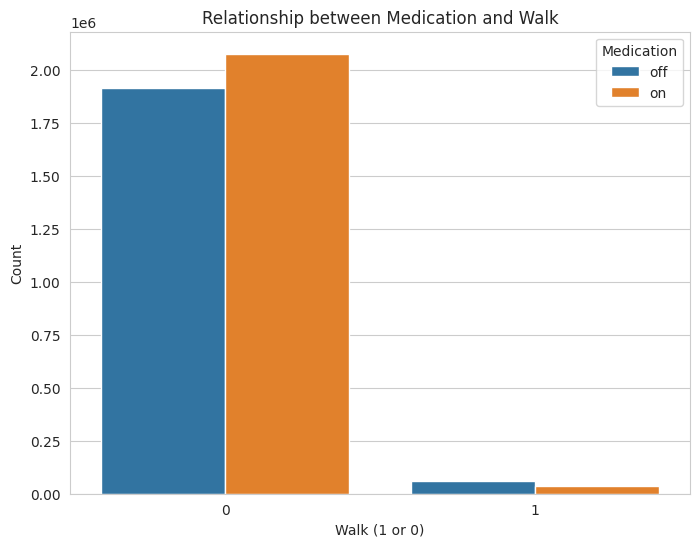

In [ ]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Create the count plot
plt.figure(figsize=(8, 6))
sns.countplot(x="Walking", hue="Medication", data=defog_m)

# Add labels and title
plt.title("Relationship between Medication and Walk")
plt.xlabel("Walk (1 or 0)")
plt.ylabel("Count")
plt.legend(title="Medication", loc="upper right")

# Show the plot
plt.show()

In [ ]:
# Extract counts for each category
counts = defog_m.groupby(["Walking", "Medication"]).size()

# Calculate percentage or ratio for each category
total_counts = counts.sum()
medication_counts = counts[1].sum()
no_medication_counts = counts[0].sum()

# Calculate percentage or ratio
medication_ratio = medication_counts / total_counts
no_medication_ratio = no_medication_counts / total_counts

print("Percentage of participants on medication who walk:", medication_ratio)
print("Percentage of participants not on medication who walk:", no_medication_ratio)

Percentage of participants on medication who walk: 0.02408440959973402
Percentage of participants not on medication who walk: 0.975915590400266


In [ ]:
defog_m.corr()

,Visit,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking
Visit,1.000000,0.229630,-0.140962,0.141904,-0.013925,-0.004053,-0.001295,0.116937
Time,0.229630,1.000000,0.005727,-0.092764,-0.215058,-0.000039,0.072487,0.204463
AccV,-0.140962,0.005727,1.000000,-0.050391,-0.176833,-0.000538,0.079232,-0.027536
AccML,0.141904,-0.092764,-0.050391,1.000000,-0.129091,-0.002988,0.032276,-0.005380
AccAP,-0.013925,-0.215058,-0.176833,-0.129091,1.000000,-0.000724,-0.203901,-0.002957
StartHesitation,-0.004053,-0.000039,-0.000538,-0.002988,-0.000724,1.000000,-0.004525,-0.001737
Turn,-0.001295,0.072487,0.079232,0.032276,-0.203901,-0.004525,1.000000,-0.064292
Walking,0.116937,0.204463,-0.027536,-0.005380,-0.002957,-0.001737,-0.064292,1.000000


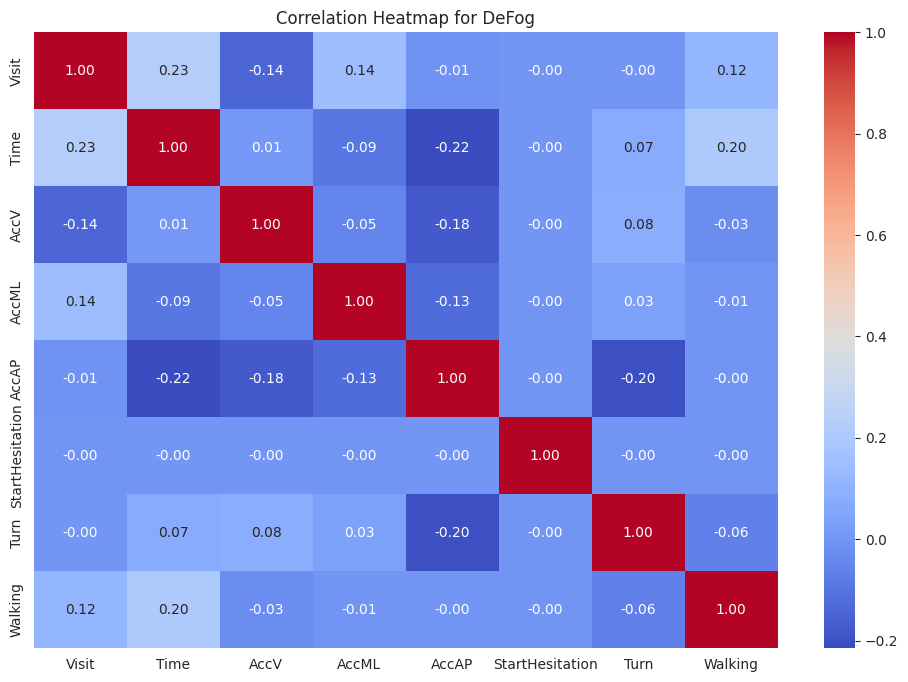

In [ ]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(defog_m.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for DeFog')
plt.show()

*   Positive Correlations:

There is a moderate positive correlation (0.23) between "Time" and "Visit", indicating that as time increases, the number of visits tends to increase as well.

A weak positive correlation (0.14) is also seen between "StartHesitation" and "Visit".

There is a moderate positive correlation (0.20) between "Time" and "Walking", suggesting that more times may be associated with increased walking activity.

A weak positive correlation (0.12) is observed between "Walking" and "Visit", suggesting that more visits may be associated with increased walking activity.

Similarly, there is a weak positive correlation (0.14) between "AccML" (mediolateral acceleration) and "Visit", indicating that a higher degree of mediolateral acceleration may be associated with more instances of Visit.


*   Negative Correlations:

There is a weak negative correlation (-0.20) between "AccAP" (anteroposterior acceleration) and "Turn", suggesting that higher levels of anteroposterior acceleration may be associated with fewer instances of Turn at the start.

A weak negative correlation (-0.22) is observed between "Time" and "AccAP", implying that as time increases, there might be a slight decrease in anteroposterior acceleration.

In [ ]:
# Selecting the target columns
target_columns = ['StartHesitation', 'Turn', 'Walking']

# Creating a DataFrame with only the target columns
target_df = defog_m[target_columns]
for column in target_df.columns:
    print(target_df[column].value_counts())


0    4090030
1        500
Name: StartHesitation, dtype: int64
0    3503701
1     586829
Name: Turn, dtype: int64
0    3992012
1      98518
Name: Walking, dtype: int64


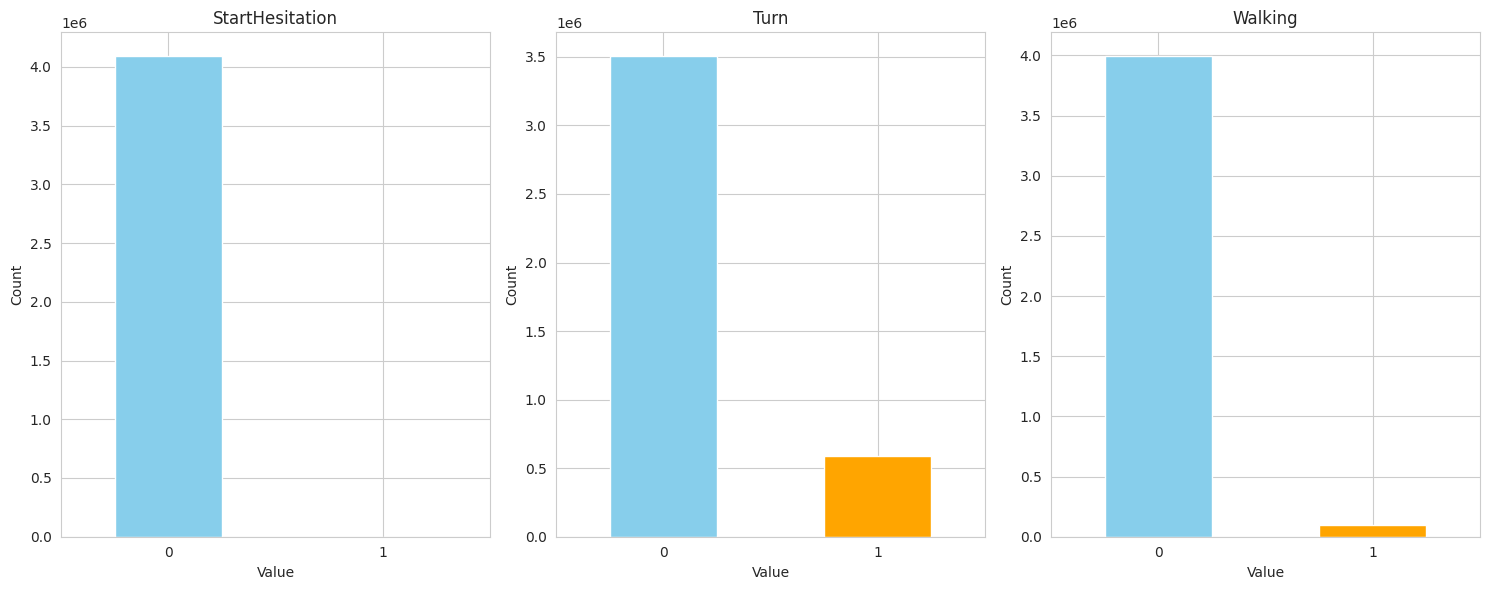

In [ ]:
# Plotting the bar chart for each target column
plt.figure(figsize=(15, 6))

for i, column in enumerate(target_df.columns):
    plt.subplot(1,3,i+1)
    target_df[column].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

### Visualize patterns and differences in acceleration behavior during different activities.

In [ ]:
def numerizeData(df):
    # Initialize a dictionary to store summary statistics
    summary_stats = {}

    # Iterate over unique movements
    unique_movements = df['Walking'].unique()
    for movement in unique_movements:
        subset = df[df['Walking'] == movement]
        if not subset.empty:
            # Initialize a dictionary to store summary statistics for each feature
            feature_stats = {}

            # Calculate summary statistics for each feature
            for feature in ['AccV', 'AccML', 'AccAP']:
                feature_stats[feature + '_mean'] = subset[feature].mean()
                feature_stats[feature + '_std'] = subset[feature].std()
                feature_stats[feature + '_min'] = subset[feature].min()
                feature_stats[feature + '_max'] = subset[feature].max()

            # Store summary statistics for the current movement
            summary_stats[movement] = feature_stats

    return summary_stats

# Call the function with your dataset
summary_statistics = numerizeData(defog_m)

# Print summary statistics
for movement, stats in summary_statistics.items():
    print(f'Movement: {movement}')
    for feature, values in stats.items():
        print(f'{feature}: {values}')
    print('\n')


Movement: 0
AccV_mean: nan
AccV_std: 0.0
AccV_min: -6.0234375
AccV_max: 4.45703125
AccML_mean: -0.0
AccML_std: 0.0
AccML_min: -2.115234375
AccML_max: 4.5234375
AccAP_mean: nan
AccAP_std: 0.0
AccAP_min: -5.1171875
AccAP_max: 4.38671875


Movement: 1
AccV_mean: nan
AccV_std: 0.0
AccV_min: -2.771484375
AccV_max: -0.25537109375
AccML_mean: -0.0
AccML_std: 0.0
AccML_min: -0.9072265625
AccML_max: 0.81298828125
AccAP_mean: -0.0
AccAP_std: 0.0
AccAP_min: -1.267578125
AccAP_max: 0.40673828125




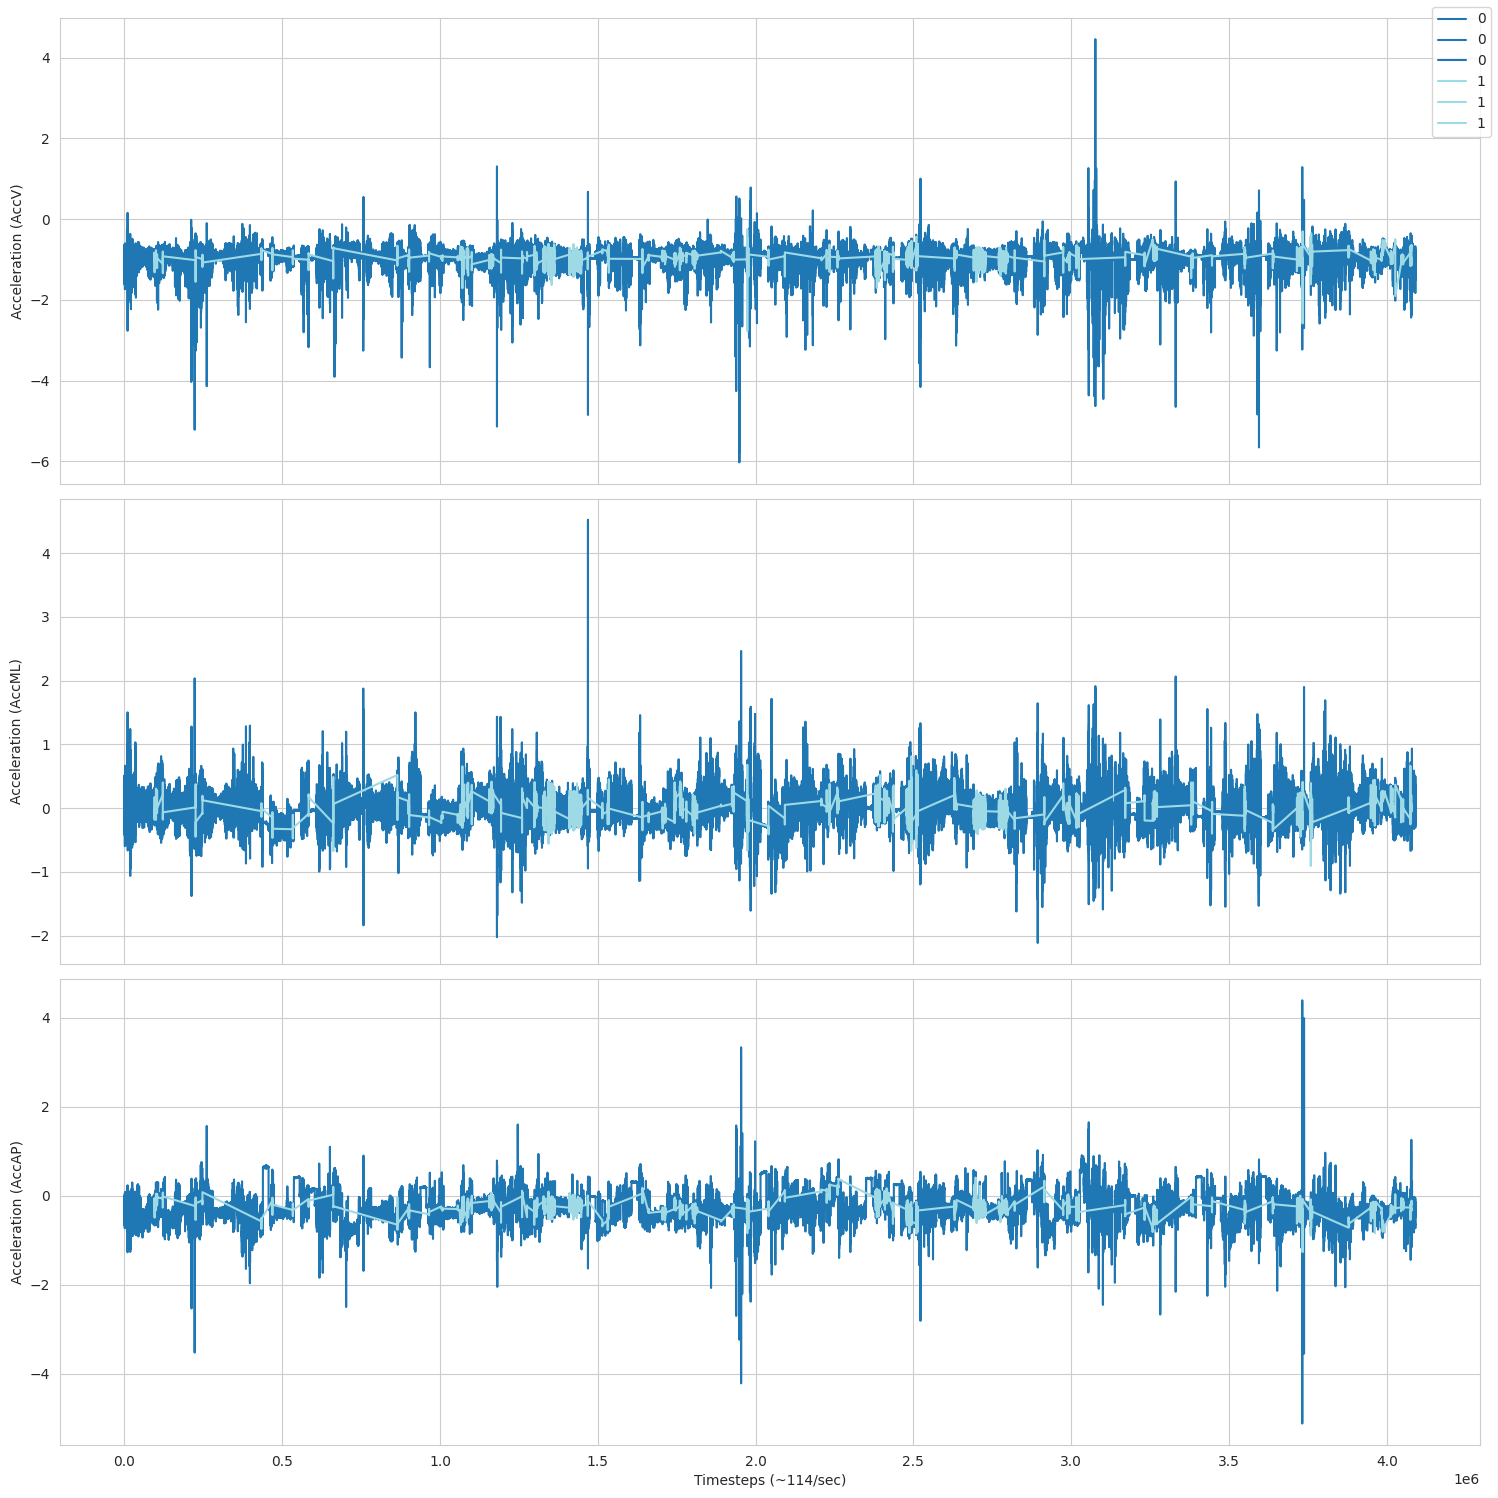

In [ ]:
import matplotlib.pyplot as plt

def labelPlot(df):
    # Set up the figure and axes for subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

    # Iterate over unique movements to assign different colors
    unique_movements = df['Walking'].unique()  # 'Walking' is the target variable
    colors = plt.cm.get_cmap('tab20', len(unique_movements))
    handles = []  # To store legend handles
    labels = []   # To store Legend Labels

    # Plot each segment with a different color
    for movement, color in zip(unique_movements, colors.colors):
        subset = df[df['Walking'] == movement]
        if not subset.empty:
            for i, feature in enumerate(['AccV', 'AccML', 'AccAP']):
                ax = axes[i]
                ax.plot(subset[feature], label=movement, color=color)  # Plot the feature
                ax.set_ylabel(f'Acceleration ({feature})')
                handles.append(ax.lines[-1])
                labels.append(movement)

    # Customize the plot
    fig.legend(handles=handles, labels=labels, loc='upper right')
    plt.xlabel('Timesteps (~114/sec)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with your dataset
labelPlot(defog_m)



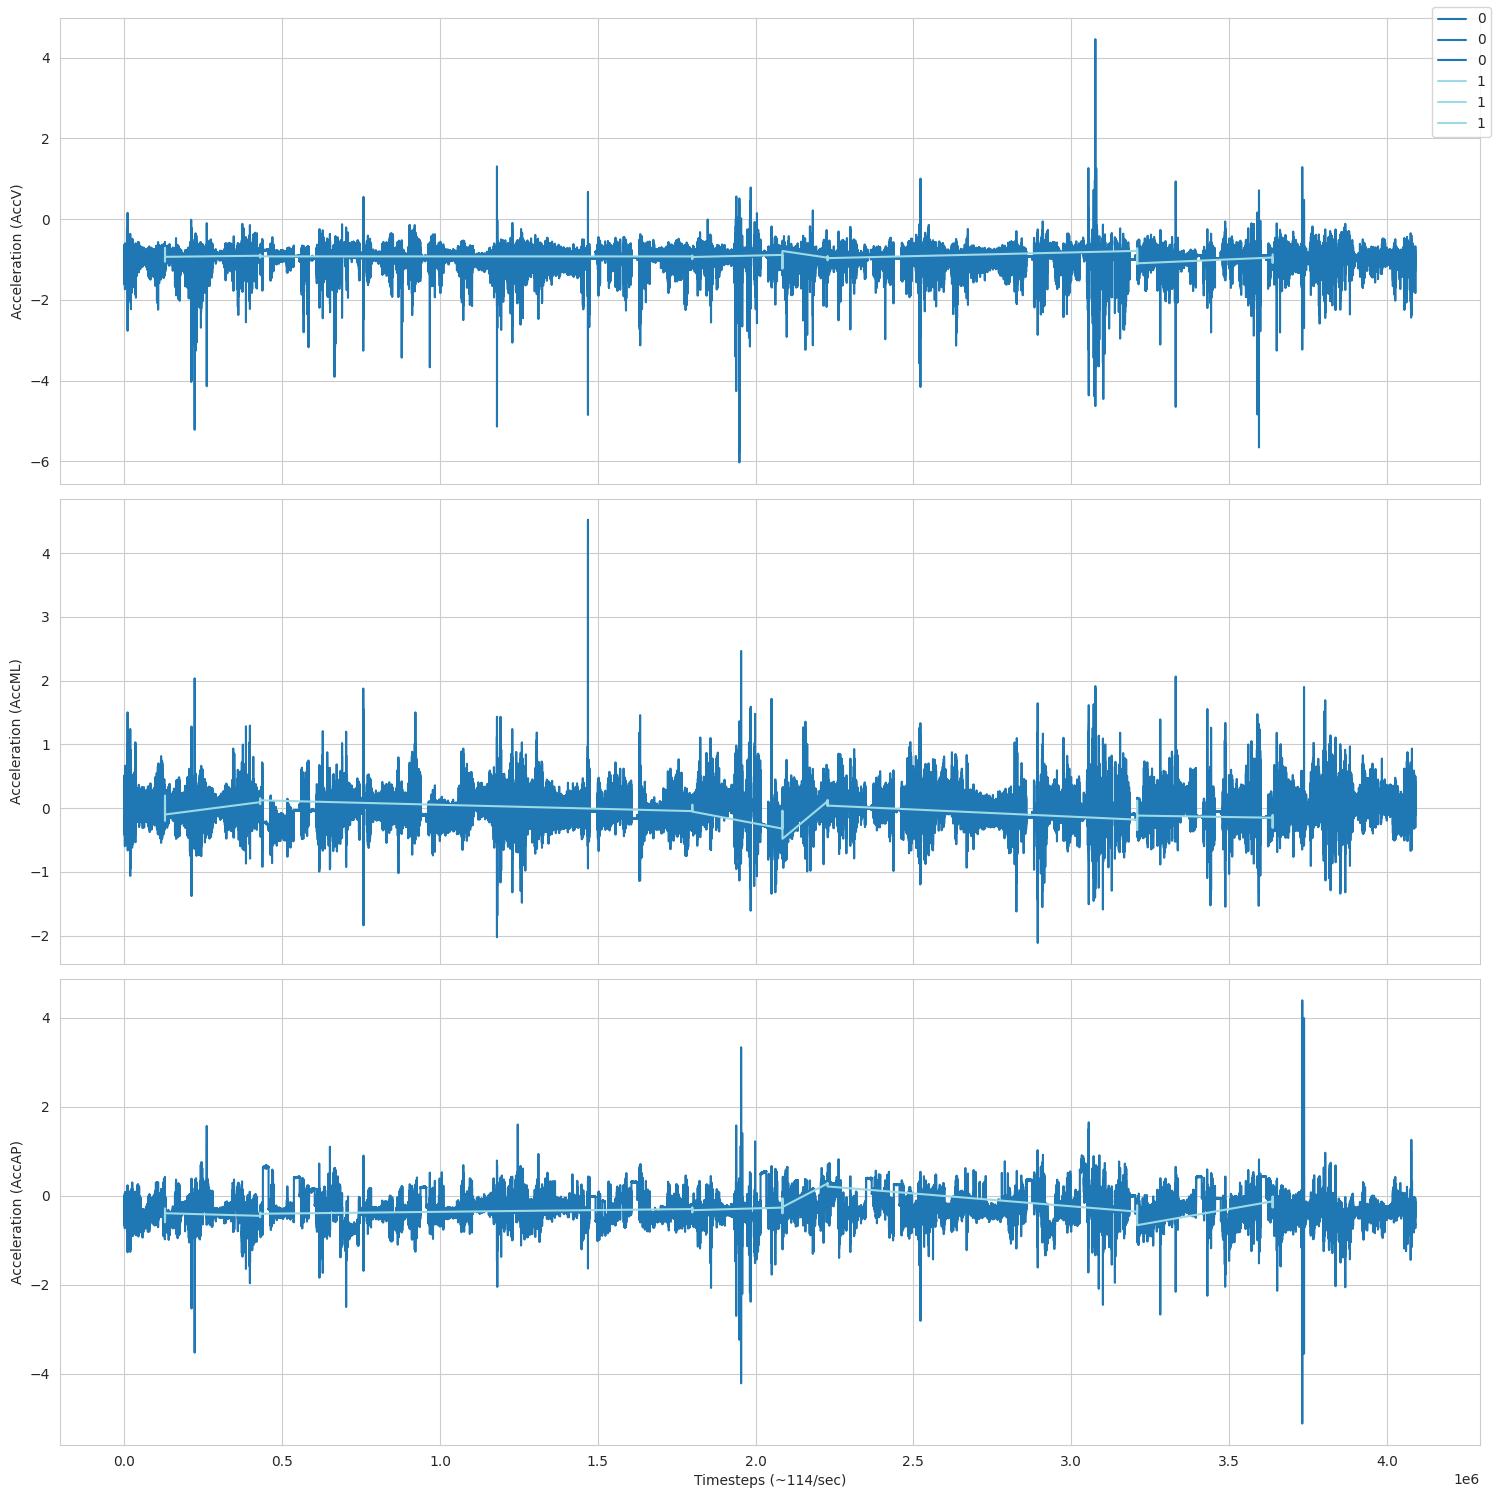

In [ ]:
import matplotlib.pyplot as plt

def labelPlot(df):
    # Set up the figure and axes for subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

    # Iterate over unique movements to assign different colors
    unique_movements = df['StartHesitation'].unique()  # 'Walking' is the target variable
    colors = plt.cm.get_cmap('tab20', len(unique_movements))
    handles = []  # To store legend handles
    labels = []   # To store Legend Labels

    # Plot each segment with a different color
    for movement, color in zip(unique_movements, colors.colors):
        subset = df[df['StartHesitation'] == movement]
        if not subset.empty:
            for i, feature in enumerate(['AccV', 'AccML', 'AccAP']):
                ax = axes[i]
                ax.plot(subset[feature], label=movement, color=color)  # Plot the feature
                ax.set_ylabel(f'Acceleration ({feature})')
                handles.append(ax.lines[-1])
                labels.append(movement)

    # Customize the plot
    fig.legend(handles=handles, labels=labels, loc='upper right')
    plt.xlabel('Timesteps (~114/sec)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with your dataset
labelPlot(defog_m)



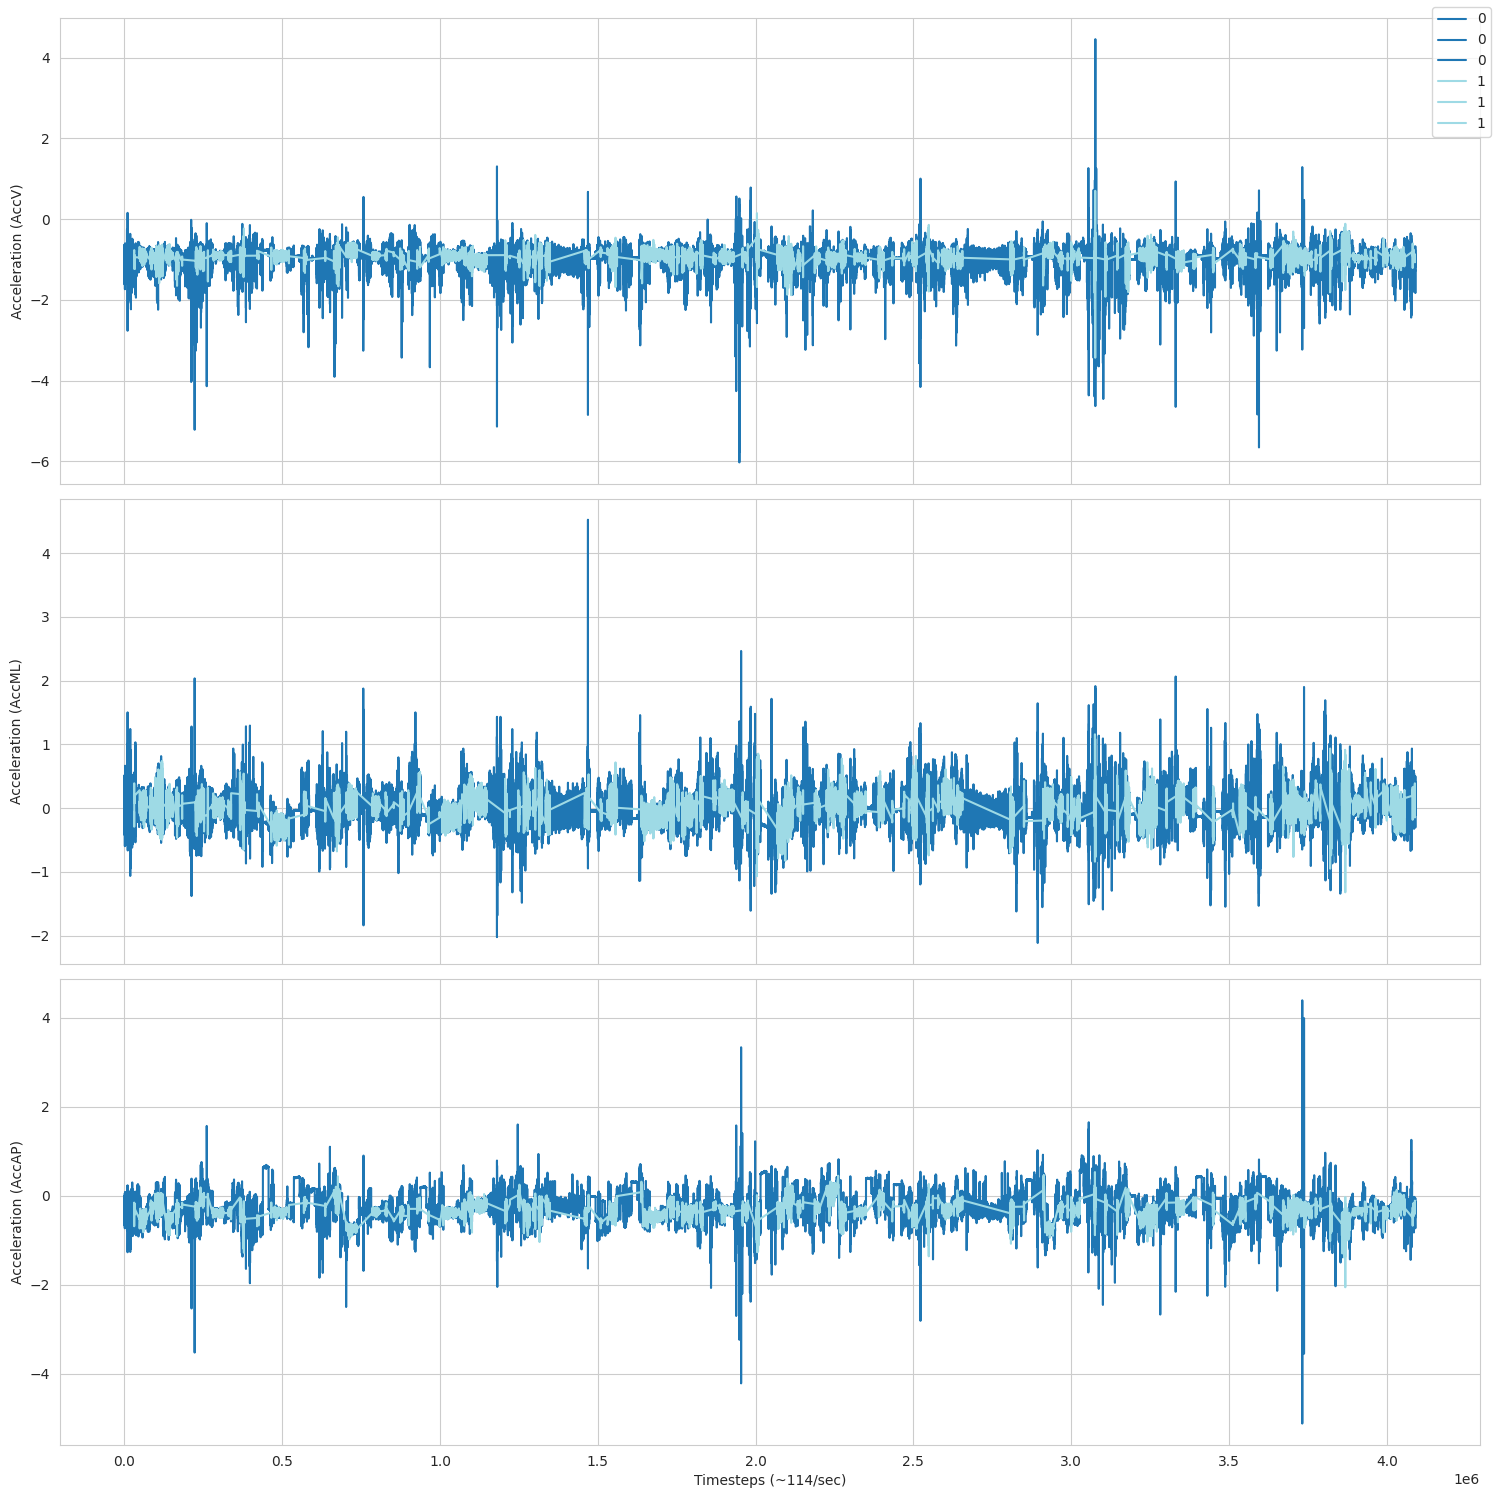

In [ ]:
import matplotlib.pyplot as plt

def labelPlot(df):
    # Set up the figure and axes for subplots
    fig, axes = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

    # Iterate over unique movements to assign different colors
    unique_movements = df['Turn'].unique()  # 'Walking' is the target variable
    colors = plt.cm.get_cmap('tab20', len(unique_movements))
    handles = []  # To store legend handles
    labels = []   # To store Legend Labels

    # Plot each segment with a different color
    for movement, color in zip(unique_movements, colors.colors):
        subset = df[df['Turn'] == movement]
        if not subset.empty:
            for i, feature in enumerate(['AccV', 'AccML', 'AccAP']):
                ax = axes[i]
                ax.plot(subset[feature], label=movement, color=color)  # Plot the feature
                ax.set_ylabel(f'Acceleration ({feature})')
                handles.append(ax.lines[-1])
                labels.append(movement)

    # Customize the plot
    fig.legend(handles=handles, labels=labels, loc='upper right')
    plt.xlabel('Timesteps (~114/sec)')

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with your dataset
labelPlot(defog_m)



## Modeling

In [ ]:
defog = pd.read_csv('/content/drive/MyDrive/DSC672/finaldataset/full_defog.csv')

In [ ]:
defog = reduce_memory_usage(defog)

Memory usage of dataframe is 374.50 MB
Memory usage became:  74.1197566986084  MB


In [ ]:
defog.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Medication,Age,Sex,YearsSinceDx,NFOGQ
0,1000,-0.953613,0.023209,-0.397949,0,0,0,0,61,0,7.0,22
1,1001,-0.963867,0.024414,-0.398438,0,0,0,0,61,0,7.0,22
2,1002,-0.968262,0.028320,-0.387939,0,0,0,0,61,0,7.0,22
3,1003,-0.965332,0.028351,-0.371582,0,0,0,0,61,0,7.0,22
4,1004,-0.954590,0.029755,-0.362061,0,0,0,0,61,0,7.0,22


In [ ]:
def preprocess_data(data):
    # Extract features and target variables
    X = data[['AccV', 'AccML', 'AccAP']].values
    y = data[['StartHesitation', 'Turn', 'Walking']].values

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Reshape features for LSTM
    X = X.reshape((X.shape[0], 1, X.shape[1]))

    # Convert target variables to integers
    y = np.argmax(y, axis=1)

    # Split data into training and testing sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=42)

    return trainX, trainy, testX, testy

def evaluate_model(trainX, trainy, testX, testy, epochs):
    verbose, epochs, batch_size = 1, epochs, 64
    n_outputs = trainy.shape[1]  # Number of output variables

    # Define callbacks
    callback = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    # Define model
    model = Sequential(name='LSTM_Model')
    model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Dense(3))  # Output layer with 3 neurons for 3 target variables

    # Compile model
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    model.summary()

    # Fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[callback, mc])

    # Evaluate model
    saved_model = load_model('best_model.h5')
    loss, accuracy, precision, recall = saved_model.evaluate(testX, testy, batch_size=batch_size, verbose=1)

    # Make predictions
    predictions = saved_model.predict(testX)

    return history, predictions, accuracy, loss, precision, recall

In [ ]:
trainX, trainy, testX, testy = preprocess_data(defog)

In [ ]:
print(trainX.shape)
print(trainy.shape)
print(testX.shape)
print(testy.shape)

(3272424, 1, 3)
(3272424,)
(818106, 1, 3)
(818106,)


In [ ]:
def run_experiment(trainX, trainy, testX, testy, epochs=5, repeats=3):
    # Initialize lists to store metrics for each repetition
    accuracies = []
    precisions = []
    recalls = []
    losses = []
    histories = []
    predictions = {}

    for r in range(repeats):
        history, prediction, accuracy, precision, recall, loss = evaluate_model(trainX, trainy, testX, testy, epochs)

        # Append metrics to lists
        accuracies.append(accuracy * 100.0)
        precisions.append(precision * 100.0)
        recalls.append(recall * 100.0)
        losses.append(loss)
        histories.append(history)

        # Store predictions for each repetition
        predictions[r+1] = prediction

        # Print metrics for each repetition
        print(f"\nRepetition #{r+1}:")
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall: {recall:.3f}")
        print(f"Loss: {loss:.3f}")

    # Summarize results
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_loss = np.mean(losses)

    return histories, predictions, mean_accuracy, mean_precision, mean_recall, mean_loss


def result_plots(histories):
    # Plot accuracy, precision, recall, and loss values
    n = len(histories)

    # Lists to store mean values
    macc = histories[0].history['accuracy']
    mval_acc = histories[0].history['val_accuracy']

    mloss = histories[0].history['loss']
    mval_loss = histories[0].history['val_loss']

    if n > 1:
        # Iterate over trials/histories
        for i in range(1, n):
            # Add Lists of values for each metric together
            macc += np.array(histories[i].history['accuracy'])
            mval_acc += np.array(histories[i].history['val_accuracy'])

            mloss += np.array(histories[i].history['loss'])
            mval_loss += np.array(histories[i].history['val_loss'])

        # Get metric means of all trials
        macc /= n
        mval_acc /= n

        mloss /= n
        mval_loss /= n

    # Create a  grid of subplots
    fig, axs = plt.subplots(2, 1)

    # Plot metrics in each subplot
    axs[0].plot(macc, label='Accuracy')
    axs[0].plot(mval_acc, label='Validation Accuracy')
    axs[0].set_title('Accuracy vs Validation Accuracy')
    axs[0].legend()

    axs[1].plot(mloss, label='Loss')
    axs[1].plot(mval_loss, label='Validation Loss')
    axs[1].set_title('Loss vs Validation Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def result_plots(histories):
    # Plot accuracy, precision, recall, and loss values
    n = len(histories)

    # Lists to store mean values
    macc = histories[0].history['accuracy']
    mval_acc = histories[0].history['val_accuracy']

    mloss = histories[0].history['loss']
    mval_loss = histories[0].history['val_loss']

    if n > 1:
        # Iterate over trials/histories
        for i in range(1, n):
            # Add Lists of values for each metric together
            macc += np.array(histories[i].history['accuracy'])
            mval_acc += np.array(histories[i].history['val_accuracy'])

            mloss += np.array(histories[i].history['loss'])
            mval_loss += np.array(histories[i].history['val_loss'])

        # Get metric means of all trials
        macc /= n
        mval_acc /= n

        mloss /= n
        mval_loss /= n

    # Create a  grid of subplots
    fig, axs = plt.subplots(2, 1)

    # Plot metrics in each subplot
    axs[0].plot(macc, label='Accuracy')
    axs[0].plot(mval_acc, label='Validation Accuracy')
    axs[0].set_title('Accuracy vs Validation Accuracy')
    axs[0].legend()

    axs[1].plot(mloss, label='Loss')
    axs[1].plot(mval_loss, label='Validation Loss')
    axs[1].set_title('Loss vs Validation Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def tunePipeline(trainX, trainy, testX, testy):
    # Reshape and standardize arrays
    scaler = MinMaxScaler(feature_range=(-1, 1))
    trainX = scaler.fit_transform(trainX.reshape(-1, trainX.shape[-1])).reshape(trainX.shape)
    testX = scaler.transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)

    # One-hot encode y
    trainy_encoded = to_categorical(trainy)
    testy_encoded = to_categorical(testy)

    # Verify the shape of one-hot encoded labels
    print("Shape of trainy_encoded:", trainy_encoded.shape)
    print("Shape of testy_encoded:", testy_encoded.shape)

    # Fit and evaluate model
    histories, predictions, a, p, r, l = run_experiment(trainX, trainy_encoded, testX, testy_encoded, 5, 3)

    # Plot training/validation scores for each epoch
    result_plots(histories)

    return histories, predictions, a, p, r, l


Shape of trainy_encoded: (3272424, 3)
Shape of testy_encoded: (818106, 3)
Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 17603 (68.76 KB)
Trainable params: 17603 (68.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
51122/51132 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.8273 - precision: 0.8329 - recall: 0.7010
Epoch 1: val_loss improved from inf to 0.09203, saving model to best_model.h5
51132/51132 [==============================] - 229s 4ms/step - loss: 0.1155 - accuracy: 0.8273 - precision: 0.8329 - recall: 0.7

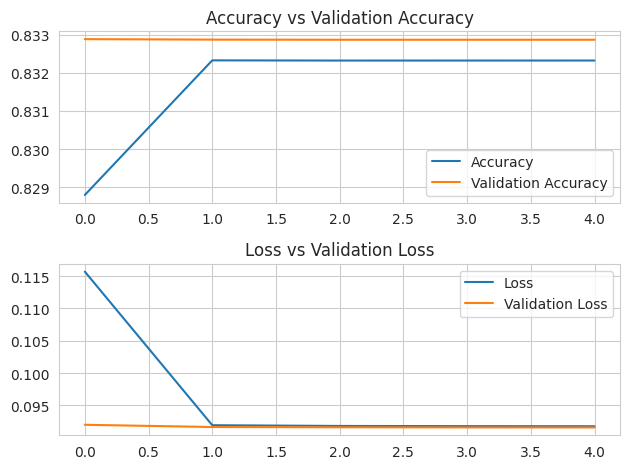

In [ ]:
histories, predictions, a, p, r, l = tunePipeline(trainX, trainy, testX, testy)